# Transformer网络结构解读及Pytorch简单实现

## 1、前言
transformer作为大模型基础的网络架构，了解其中的实现原理是AI从业人员的基础要求。本文借助网络资料及Chat-gpt，基于Pytorch实现了一个基本的Transform模型。

In [5]:
from IPython.display import IFrame
IFrame('https://arxiv.org/pdf/1706.03762', width=1000, height=700)

## 2、词向量及位置编码
一般而言，Transformer的介绍基本从Attention机制说起，但是本文的思路是构造一个端到端的Transformer模型用于训练，所以我们先从模型的输入开始。

### 2.1、词向量：

In [6]:
import torch
import torch.nn as nn
from torchsummary import summary
import numpy as np

# 定义词汇表大小和词向量维度
vocab_size = 10000
d_model = 300

# 创建嵌入层对象
embedding = nn.Embedding(vocab_size, d_model)

# 定义输入序列
input_seq = torch.LongTensor([[1, 2, 3, 4, 5]])
print("input_seq:", input_seq)

# 将输入序列传递给嵌入层
embedded_seq = embedding(input_seq)
print("embedded_seq:\n", embedded_seq)

# 打印嵌入后的序列形状
print("embedded_seq shape:", embedded_seq.shape)

input_seq: tensor([[1, 2, 3, 4, 5]])
embedded_seq:
 tensor([[[ 0.9452,  1.8137, -0.7452,  ..., -0.8337,  0.7636, -0.5987],
         [ 0.0576,  1.5101,  0.3915,  ...,  1.9072, -1.1401, -1.7490],
         [ 0.5564, -0.9509,  1.2063,  ...,  1.0732,  0.5059, -1.6580],
         [-1.7023,  1.2289,  0.1463,  ...,  0.8617,  1.3824, -0.9983],
         [-0.9744,  0.8369,  0.4043,  ..., -1.7048,  0.8906,  0.0473]]],
       grad_fn=<EmbeddingBackward0>)
embedded_seq shape: torch.Size([1, 5, 300])


In [7]:
from torchtext.datasets import Multi30k
from torchtext.data import Field, TabularDataset, BucketIterator, Iterator

#定义一个简单的分词器
tokenize = lambda x: x.split()

source_field = Field(tokenize=tokenize, tokenizer_language='en', init_token='<sos>', eos_token='<eos>')
target_field = Field(tokenize=tokenize, tokenizer_language='de', init_token='<sos>', eos_token='<eos>')
train_data, valid_data, test_data = Multi30k.splits(exts=('.en', '.de'), fields=(source_field, target_field))

In [8]:
for i in range(5):
    print(train_data[i].src)
    print(train_data[i].trg)
    print("-"*100)


['Two', 'young,', 'White', 'males', 'are', 'outside', 'near', 'many', 'bushes.']
['Zwei', 'junge', 'weiße', 'Männer', 'sind', 'im', 'Freien', 'in', 'der', 'Nähe', 'vieler', 'Büsche.']
----------------------------------------------------------------------------------------------------
['Several', 'men', 'in', 'hard', 'hats', 'are', 'operating', 'a', 'giant', 'pulley', 'system.']
['Mehrere', 'Männer', 'mit', 'Schutzhelmen', 'bedienen', 'ein', 'Antriebsradsystem.']
----------------------------------------------------------------------------------------------------
['A', 'little', 'girl', 'climbing', 'into', 'a', 'wooden', 'playhouse.']
['Ein', 'kleines', 'Mädchen', 'klettert', 'in', 'ein', 'Spielhaus', 'aus', 'Holz.']
----------------------------------------------------------------------------------------------------
['A', 'man', 'in', 'a', 'blue', 'shirt', 'is', 'standing', 'on', 'a', 'ladder', 'cleaning', 'a', 'window.']
['Ein', 'Mann', 'in', 'einem', 'blauen', 'Hemd', 'steht', 'auf', '

In [9]:
source_field.build_vocab(train_data, min_freq=2)
target_field.build_vocab(train_data, min_freq=2)

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data),
    batch_size=5,
    device="cpu"
)

sample_data = next(iter(train_iterator))
print("第一个sample的src从str转换成int:\n",sample_data.src.T)
print("第一个sample的src的shape:\n", sample_data.src.T.shape)
print("将这个sample的src转回str:")
for i in range(sample_data.src.T.shape[0]):
    print([source_field.vocab.itos[i] for i in sample_data.src.T[i]])

第一个sample的src从str转换成int:
 tensor([[   2,    5,   22,   56,  154, 6915,   44,    4,   15,   13,  328,   60,
          786,    3,    1,    1,    1,    1],
        [   2,   43,   31,  178,    0,    9,   19,    4,   30,  704,    3,    1,
            1,    1,    1,    1,    1,    1],
        [   2,    5,  639,   10,   58,   22,   74,  126,    8,    4,  673,   98,
            9,   66,    8,    7, 1989,    3],
        [   2,    5,   31,    6,    4,   21,   27,    9, 1260,    3,    1,    1,
            1,    1,    1,    1,    1,    1],
        [   2,   17, 2271,  429,   46,    4,  152,    6,    7, 3127,    3,    1,
            1,    1,    1,    1,    1,    1]])
第一个sample的src的shape:
 torch.Size([5, 18])
将这个sample的src转回str:
['<sos>', 'A', 'young', 'child', 'being', 'hugged', 'by', 'a', 'woman', 'with', 'light', 'brown', 'hair.', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>']
['<sos>', 'The', 'girl', 'eating', '<unk>', 'is', 'wearing', 'a', 'red', 'jacket.', '<eos>', '<pad>', '<pad>', '<pad>', '<pa

In [10]:
# 打印数据集信息
print(f"训练集大小: {len(train_data.examples)}")
print(f"验证集大小: {len(valid_data.examples)}")
print(f"测试集大小: {len(test_data.examples)}")
print(f"英文词汇表大小: {len(source_field.vocab)}")
print(f"德文词汇表大小: {len(target_field.vocab)}")

训练集大小: 29000
验证集大小: 1014
测试集大小: 1000
英文词汇表大小: 7964
德文词汇表大小: 9762


从上文，我们获取了一个英德数据集，并且我们获取了二者的词汇表大小。并且在通过BucketIterator处理数据集之后，我们获取了三个元素。
*  \<sos>  \<eos> \<pad>  
并且可以观察得出，sos对应的是2，eos对应的是3，pad对应的是1  
值得注意的是，统一batch中的sentence由于句长不同，我们做了pad，这也引入了后面的Padding Mask。  
现在我们可以开始构建transformer的第一个组件了，InputEmbedding，OutputEmbedding。
现在这个Transformer模型出生了:
```python
class Transformer(nn.Module):
    def __init__(self, input_dim, output_dim, d_model):
        #InputEmbedding
        self.encoder_embedding = nn.Embedding(input_dim, d_model)
        #OutputEmbedding
        self.decoder_embedding = nn.Embedding(output_dim, d_model)
```
一开始长的简陋，但是我们一点点补充他的能力。那按照之前embedding的定义和数据集的情况  
`input_dim=len(source_field.vocab)`  
`output_dim=len(target_field.vocab)`

d_modle这个变量会伴随整个transformer网络的定义过程。  
模型的输入的shape为\[batch, seq_len\]  
经过embedding之后变为\[batch, seq_len, d_model\]  

### 2.2、位置编码

In [11]:
# 定义位置编码层
import math
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()

        pe = torch.zeros(max_len, d_model)  
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp((torch.arange(0, d_model, 2, dtype=torch.float) *
                              -(math.log(10000.0) / d_model)))

        pe[:, 0::2] = torch.sin(position.float() * div_term)
        pe[:, 1::2] = torch.cos(position.float() * div_term)
        pe = pe.unsqueeze(1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return x


结合位置编码的公式来看
$$ PE(pos, 2i) = sin(pos / 10000^{2i/d_{model}}) $$  
$$ PE(pos, 2i + 1) = cos(pos / 10000^{2i/d_{model}}) $$  





## 3、Attention is all you need
说完数据的embedding和位置编码，这个章节我们会介绍Self-Attention，MultiHeadAttention以及Decoder中的Mask-Multi-Head-Attention。

### 3.1、Self-Attention

#### Step 1
计算QKV
![](https://jalammar.github.io/images/t/transformer_self_attention_vectors.png)

$$ q_{1} = x_{1} * W^{Q} $$  
$$ k_{1} = x_{1} * W^{K} $$  
$$ v_{1} = x_{1} * W^{V} $$  
$$ q_{2} = x_{2} * W^{Q} $$  
$$ k_{2} = x_{2} * W^{K} $$  
$$ v_{2} = x_{2} * W^{V} $$  

> 可以注意到，上述过程中，不同x分享了同一个W,通过这个操作，和已经发生了某种程度上的信息交换。也就是说，单词和单词之间，通过共享权值，已经相互发生了信息的交换。

到这里，我们的SelfAttenion可以增加三个组件了,并且forward可以初步定义了：
```
class SelfAttention(nn.Module):
    def __init__(self, d_model):
        super(SelfAttention, self).__init__()
        self.d_model = d_model
        
        self.query = nn.Linear(d_model, d_model)
        self.key = nn.Linear(d_model, d_model)
        self.value = nn.Linear(d_model, d_model)
    def forward(self, x):
        # 计算query、key、value
        query = self.query(x)
        key = self.key(x)
        value = self.value(x)
```


#### Step2
计算一个“score”
![](https://jalammar.github.io/images/t/transformer_self_attention_score.png)
> 假设我们正在计算本例中第一个单词“Thinking”的自注意力。我们需要根据输入句子的每个单词对这个单词进行评分。当我们在某个位置对单词进行编码时，分数决定了对输入句子的其他部分的关注程度。（机翻）

$$ score_{1} = q_{1} * k_{1}^{T} $$  
$$ score_{2} = q_{2} * k_{2}^{T} $$  

到这里，我们的SelfAttenion继续进化:
```python
class SelfAttention(nn.Module):
    def __init__(self, d_model):
        ...
        
    def forward(self, x):
        # 计算query、key、value
        query = self.query(x)
        key = self.key(x)
        value = self.value(x)
        
        # 计算注意力分数
        scores = torch.matmul(query, key.transpose(-2, -1))
```

#### Step2-3
计算由“score”组成的Attention Weight

![](https://jalammar.github.io/images/t/self-attention_softmax.png)  
   
     
$$ attention\_weight =  softmax(score/\sqrt{8})$$  
这里的8是一个经验值，我们重实现，不重炼丹，忽略。
到这里，我们的SelfAttenion继续进化:
```python
class SelfAttention(nn.Module):
    def __init__(self, input_dim, d_model):
        ...
        
    def forward(self, x):
        # 计算query、key、value
        query = self.query(x)
        key = self.key(x)
        value = self.value(x)
        
        # 计算注意力分数
        scores = torch.matmul(query, key.transpose(-2, -1))
        
        # 计算Attention Weight
        attn_weights = torch.softmax(scores / torch.sqrt(torch.tensor(8)), dim=-1)
```

#### Step4
与V联合，计算出一个“Context”
![](https://jalammar.github.io/images/t/self-attention-output.png)

最终的SelfAttenion如下:
```python
class SelfAttention(nn.Module):
    def __init__(self, d_model):
        ...
        
    def forward(self, x):        
        # 计算query、key、value
        query = self.query(x)
        key = self.key(x)
        value = self.value(x)
        
        # 计算注意力分数
        scores = torch.matmul(query, key.transpose(-2, -1))
        
        # 计算Attention Weight
        attn_weights = torch.softmax(scores / torch.sqrt(torch.tensor(8)), dim=-1)
        
        #计算context
        context = torch.matmul(attn_weights, value)
        return context, attn_weights
```

In [12]:
class SelfAttention(nn.Module):
    def __init__(self, input_dim, d_model):
        super(SelfAttention, self).__init__()
        self.d_model = d_model
        
        self.query = nn.Linear(input_dim, d_model)
        self.key = nn.Linear(input_dim, d_model)
        self.value = nn.Linear(input_dim, d_model)
        
    def forward(self, q, k, v):
        # 计算query、key、value
        query = self.query(q)
        print("query shape:", query.shape)
        key = self.key(v)
        print("key shape:", key.shape)
        value = self.value(v)
        print("value shape:", value.shape)
        
        # 计算注意力权重
        scores = torch.matmul(query, key.transpose(-2, -1))
        print("scores shape:", scores.shape)
        print(f"score的shape含义代表，这{q.size(0)}个句子里，每个token和其他同在一条语句中的token之间的联系")
        attn_weights = torch.softmax(scores / torch.sqrt(torch.tensor(8.0)), dim=-1)
        print("attn_weights shape:", attn_weights.shape)
        # 使用注意力权重加权得到上下文向量
        context = torch.matmul(attn_weights, value)
        print("context shape:", context.shape)
        return context, attn_weights

我们来用上文中获取到的`sampel_data`来跑一个SelfAttention，加深下理解,之前数据集的信息
```
第一个数据集从str转换成int: tensor([[   2],
        [  43],
        [  15],
        [ 624],
        [   4],
        [2306],
        [  76],
        [  12],
        [   4],
        [2114],
        [   0],
        [   3]])
训练集大小: 29000
验证集大小: 1014
测试集大小: 1000
英文词汇表大小: 7964
德文词汇表大小: 9762
```

In [13]:
sample_data
# 英文词汇表大小: 7964，我们设置d_model为300
sample_embedding = nn.Embedding(7964, 300)
e = sample_data.src.T
print(f"输入shape是{e.shape},代表的是说一共有{e.size(0)}个句子，每个句子被pad成了{e.size(1)}的长度")
print("输入长这样：\n", e)
e = sample_embedding(e)
# print(e) 
print(f"通过词嵌入后，shape变成了{e.shape}，这代表一共有{e.size(0)}个句子,\n",
      f"每个句子有{e.size(1)}个token，每个token被映射到一个{e.size(2)}维空间")
    
sample_pe = PositionalEncoding(300)
e = sample_pe(e)
# print(e)
print(f"经过了位置编码后，shape不变，依然为{e.shape}")

sample_sa = SelfAttention(300, 300)

e, _ = sample_sa(e, e, e)
# print(e)
print(f"最终输出shape {e.shape}，与q，k，v shape相同")



输入shape是torch.Size([5, 18]),代表的是说一共有5个句子，每个句子被pad成了18的长度
输入长这样：
 tensor([[   2,    5,   22,   56,  154, 6915,   44,    4,   15,   13,  328,   60,
          786,    3,    1,    1,    1,    1],
        [   2,   43,   31,  178,    0,    9,   19,    4,   30,  704,    3,    1,
            1,    1,    1,    1,    1,    1],
        [   2,    5,  639,   10,   58,   22,   74,  126,    8,    4,  673,   98,
            9,   66,    8,    7, 1989,    3],
        [   2,    5,   31,    6,    4,   21,   27,    9, 1260,    3,    1,    1,
            1,    1,    1,    1,    1,    1],
        [   2,   17, 2271,  429,   46,    4,  152,    6,    7, 3127,    3,    1,
            1,    1,    1,    1,    1,    1]])
通过词嵌入后，shape变成了torch.Size([5, 18, 300])，这代表一共有5个句子,
 每个句子有18个token，每个token被映射到一个300维空间
经过了位置编码后，shape不变，依然为torch.Size([5, 18, 300])
query shape: torch.Size([5, 18, 300])
key shape: torch.Size([5, 18, 300])
value shape: torch.Size([5, 18, 300])
scores shape: torch.Size([5, 18, 18])
score的shape含义代表，这

可以看到上文sample表示的网络流程如下，最终Z则是我们输出的context  
![](https://jalammar.github.io/images/t/self-attention-matrix-calculation-2.png)





经过embedding和position encoding之后，self attention的输入为$[batch, seq\_len, d\_model]$  
query的shape为$[batch, seq\_len, d\_model]$, key, value的shape与query相同  
score的shape为$[batch, seq\_len, seq\_len]$  
attn_weights的shape为$[batch, seq\_len, seq\_len]$,与score的shape相同  
context的shape为$[batch, seq\_len, d\_model]$,与query，key，value的shape相同

1、$ Q \times K^{T}$    
$ [batch, seq\_len, d\_model] \times [batch, d\_model, seq\_len] = [batch, seq\_len, seq\_len]$  


2、$ softmax(\frac{Q \times K^{T}}{\sqrt(d_k)})$   
$[batch, seq\_len, seq\_len]$


3、$ softmax(\frac{Q \times K^{T}}{\sqrt dk}) \times V $  
$[batch, seq\_len, seq\_len] \times [batch, seq\_len, d\_model] = [batch, seq\_len, d\_model]$ 

### 3.2、multi-headed Attention
所谓多头注意力机制，即多个SelfAttention模块组合，这样存在多份Q，K，V权重矩阵。我们也可以很粗浅的认为，这样可以从不同的视角去理解一个句子。 如下图所示，一个8头注意力机制可以产生8个$Z(context)$矩阵。但是对于Transformer中的feedforward模块，并不想感知多个矩阵，于是就通过下图的方法，对于多头注意力，网络中添加了一个$W^{O}$，用于将concat起来之后的$[Z_{0}, Z_{1}...Z_{7}]$进行变换为$Z$。  

在了解SelfAttention的实现之后，我们发现multi-headed Attention的思想也非常朴素。所以我们可以开始实现一个multi-headed Attention。
![](https://jalammar.github.io/images/t/transformer_attention_heads_z.png)
![](https://jalammar.github.io/images/t/transformer_attention_heads_weight_matrix_o.png)

In [14]:
import torch
import torch.nn as nn

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        
        assert d_model % num_heads == 0, "Hidden dimension must be divisible by the number of heads."
        
        self.head_dim = d_model // num_heads
        
        self.attention_heads = nn.ModuleList([SelfAttention(d_model, head_dim) for _ in range(num_heads)])
        self.fc = nn.Linear(num_heads * self.head_dim, input_dim)
        
    def forward(self, x):
        attention_outputs = []
        
        for attention_head in self.attention_heads:
            context, _ = attention_head(x)
            attention_outputs.append(context)
        
        # 将多个注意力头的输出拼接在一起
        concatenated = torch.cat(attention_outputs, dim=-1)
        
        # 使用线性层进行投影
        output = self.fc(concatenated)
        
        return output


以上是一个MultiHeadAttention的简单的直观实现，这个实现是通过做head_num次SelfAttention来去获取head_num个shape为$[batch, d\_model, d\_model/num\_heads]$的context，最终合并成shape为$[batch, d\_model, d\_model]$的context。  
这样效率是比较低下的。以下是一个常见的工程实现


In [15]:
   
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, head_num, dropout):
        super().__init__()

        self.d_model = d_model
        self.head_num = head_num
        
        # d_model // h 要能整除
        assert d_model % n_heads == 0

        
        self.q = nn.Linear(d_model, d_model)
        self.k = nn.Linear(d_model, d_model)
        self.v = nn.Linear(d_model, d_model)

        self.fc = nn.Linear(d_model, d_model)

        self.dropout = nn.Dropout(dropout)
        
    def forward(self, q, k, v, mask=None):
        bsz = query.shape[0]

        query = self.q(q)
        key = self.k(k)
        value = self.v(v)

        query = query.view(bsz, -1, self.head_num, self.d_model //self.head_num).transpose(1, 2)
        key = key.view(bsz, -1, self.head_num, self.d_model //self.head_num).transpose(1, 2)
        value = value.view(bsz, -1, self.head_num, self.d_model //self.head_num).transpose(1, 2)
        
        scores = torch.matmul(query, key.permute(0, 1, 3, 2)) 
        
        attn_weights = self.dropout(torch.softmax(energy, dim=-1))

        context = torch.matmul(attn_weights, value)

        context = context.permute(0, 2, 1, 3).contiguous()

        context = context.view(bsz, -1, self.n_heads * (self.hid_dim // self.n_heads))

        context = self.fc(context)
        return context, attn_weights

$q: \ [batch, seq\_len, d\_model] \ as \ k \ v$  


$query: \ [batch, seq\_len, d\_model] \ as \ key \ value$  


`query.view(bsz, -1, self.head_num, self.d_model //self.head_num) `  
$query \ update \ as: \ [batch, seq\_len, head\_num, d\_model \div head_num]$  


`query = query.view(bsz, -1, self.head_num, self.d_model //self.head_num).transpose(1, 2)`  
$query \ update \ as: \ [batch, head\_num, seq\_len, d\_model \div head\_num] \ as \ key \ value$  


`scores = torch.matmul(query, key.permute(0, 1, 3, 2))`  
$[batch, head\_num, seq\_len, d\_model \div head\_num] \times [batch, head\_num, d\_model \div head\_num, seq\_len]$  
$scores：[batch, head\_num, seq\_len, seq\_len]$  


`context = torch.matmul(attn_weights, V)`  
$[batch, head\_num, seq\_len, seq\_len] \times [batch, head\_num, seq\_len, d\_model \div head\_num]$   
$context：[batch, head\_num, seq\_len, d\_model \div head\_num]$  


`context = context.permute(0, 2, 1, 3).contiguous()`  
$context  \ update \ as: [batch, seq\_len, head\_num, d\_model \div head\_num]$  


`context = context.view(bsz, -1, self.n_heads * (self.hid_dim // self.n_heads)`  
$context  \ update \ as: [batch, seq\_len, d\_model]$  


### 3.3、Mask-Multi-Head-Attention
我们先不着急来取看Mask-Multi-Head-Attention，移步到4章节，我们先看下encoder实现。


> mask 表示掩码，它对某些值进行掩盖，使其在参数更新时不产生效果。Transformer 模型里面涉及两种 mask，分别是 padding mask 和 sequence mask。其中，padding mask 在所有的 scaled dot-product attention 里面都需要用到，而 sequence mask 只有在 decoder 的 self-attention 里面用到。   
> Padding Mask
什么是 padding mask 呢？因为每个批次输入序列长度是不一样的也就是说，我们要对输入序列进行对齐。具体来说，就是给在较短的序列后面填充 0。但是如果输入的序列太长，则是截取左边的内容，把多余的直接舍弃。因为这些填充的位置，其实是没什么意义的，所以我们的attention机制不应该把注意力放在这些位置上，所以我们需要进行一些处理。
具体的做法是，把这些位置的值加上一个非常大的负数(负无穷)，这样的话，经过 softmax，这些位置的概率就会接近0！而我们的 padding mask 实际上是一个张量，每个值都是一个Boolean，值为 false 的地方就是我们要进行处理的地方。  
> Sequence mask
文章前面也提到，sequence mask 是为了使得 decoder 不能看见未来的信息。也就是对于一个序列，在 time_step 为 t 的时刻，我们的解码输出应该只能依赖于 t 时刻之前的输出，而不能依赖 t 之后的输出。因此我们需要想一个办法，把 t 之后的信息给隐藏起来。
那么具体怎么做呢？也很简单：产生一个上三角矩阵，上三角的值全为0。把这个矩阵作用在每一个序列上，就可以达到我们的目的。

以下是一个非常直观的mask实现: $e^{-inf} =0$,这样score对于mask为0的token的注意力就为0，那至于是Padding Mask还是Sequence mask，我们只需要控制传入的mask参数就好了。  
那我们就可以稍稍改变下MultiHeadedAttention的实现  

理解mask的要点在于我们是对什么做mask，无论是encoder还是decoder，qk的矩阵乘结果为$scores：[batch, head\_num, seq\_len, seq\_len]$  
```
scores = torch.matmul(query, key.permute(0, 1, 3, 2)) 
```



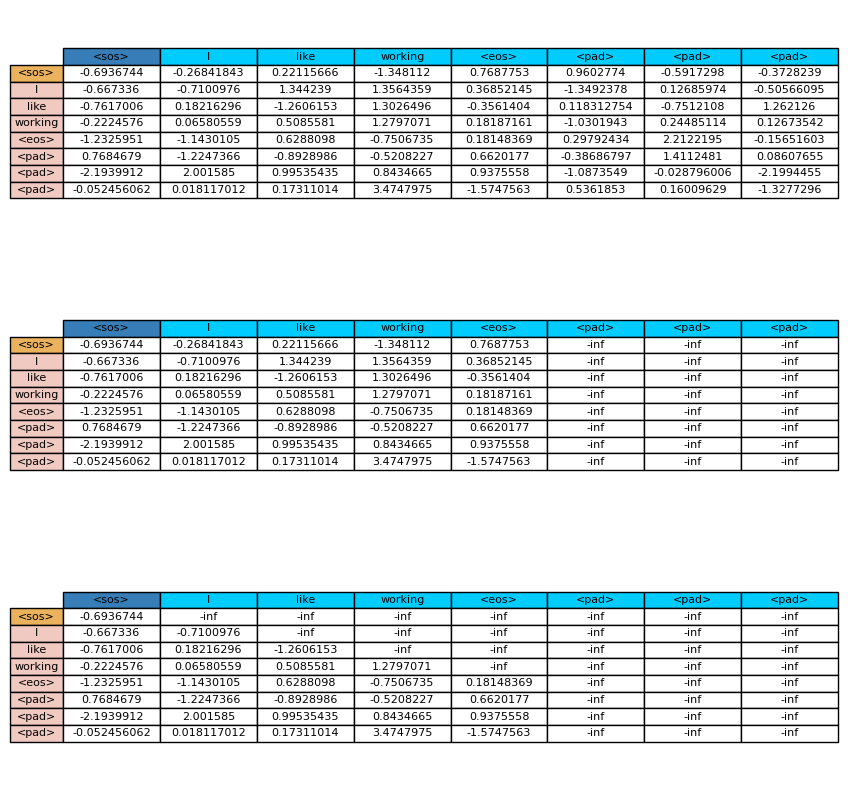

In [83]:

import matplotlib.pyplot as plt
fig, ax = plt.subplots(3, 1, figsize=(10, 10))

# 左侧边栏，如果不需要，在plt.table中注释即可
# rowLabels 与 rowColours中的数据长度要保持一致，同时和数据中的元素个数保持一致--len(data)
rowLabels = column_labels = ["<sos>", "I", "like", "working", "<eos>", "<pad>", "<pad>", "<pad>"]
rowColours = ["#EBB25E", "#F0C9C0", "#F0C9C0", "#F0C9C0", "#F0C9C0", "#F0C9C0", "#F0C9C0",  "#F0C9C0"]

# # 列表头颜色，需要和单条数据长度保持一致--len(data[0])
colColors = ["#377eb8"]
colColors.extend(["#00ccff"] * len(rowColours))

# 左侧结果图数据
#假设seq_len为8
data = torch.randn(8, 8)


ax[0].axis('off')
ax[0].table(cellText=data.numpy(),
         colLabels=column_labels,
         colColours=colColors,
         rowColours=rowColours,
         rowLabels=rowLabels,
         cellLoc='center',
         rowLoc='center',
         loc="center")


data[:, 5:] = -np.inf
ax[1].axis('off')
ax[1].table(cellText=data.numpy(),
         colLabels=column_labels,
         colColours=colColors,
         rowColours=rowColours,
         rowLabels=rowLabels,
         cellLoc='center',
         rowLoc='center',
         loc="center")

sequence_mask = torch.from_numpy(np.triu(np.ones(8), k=1)) == 0
data = data.masked_fill(sequence_mask == 0, -np.inf)
ax[2].axis('off')
ax[2].table(cellText=data.numpy(),
         colLabels=column_labels,
         colColours=colColors,
         rowColours=rowColours,
         rowLabels=rowLabels,
         cellLoc='center',
         rowLoc='center',
         loc="center")
plt.show()

In [55]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, head_num, dropout=0):
        super().__init__()

        self.d_model = d_model
        self.head_num = head_num
        
        # d_model // h 要能整除
        assert d_model % head_num == 0

        
        self.q = nn.Linear(d_model, d_model)
        self.k = nn.Linear(d_model, d_model)
        self.v = nn.Linear(d_model, d_model)

        self.fc = nn.Linear(d_model, d_model)

        self.dropout = nn.Dropout(dropout)
        
    def forward(self, q, k, v, mask=None):
        bsz = q.shape[0]
        if mask is not None:
            mask = mask.unsqueeze(1)
        query = self.q(q)
        key = self.k(k)
        value = self.v(v)

        query = query.view(bsz, -1, self.head_num, self.d_model //self.head_num).transpose(1, 2)
        key = key.view(bsz, -1, self.head_num, self.d_model //self.head_num).transpose(1, 2)
        value = value.view(bsz, -1, self.head_num, self.d_model //self.head_num).transpose(1, 2)
        
        scores = torch.matmul(query, key.permute(0, 1, 3, 2)) 
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -np.inf)
        
        attn_weights = self.dropout(torch.softmax(scores, dim=-1))

        context = torch.matmul(attn_weights, value)

        context = context.permute(0, 2, 1, 3).contiguous()

        context = context.view(bsz, -1, self.head_num * (self.d_model // self.head_num))

        context = self.fc(context)
        return context
    

## 4、Encoder
我们来看下Encoder还差哪些元素，实现了MHA后，我们还需要FeedForward模块和Add & Norm模块，其中的虚线代表的是残差连接。（残差思想见Resnet50），这里的Normalize使用的是LayerNorm而非BatchNorm，至于二者的差别，大家可以自己扩展学习下。这里我们注重实现。
![](https://jalammar.github.io/images/t/transformer_resideual_layer_norm.png)

In [18]:
import torch
import torch.nn as nn
import numpy as np

class FeedForward(nn.Module):
    def __init__(self, d_model, ff_dim, dropout):
        super(FeedForward, self).__init__()
        self.d_model = d_model
        self.ff_dim = ff_dim
        
        self.fc1 = nn.Linear(d_model, ff_dim)
        self.fc2 = nn.Linear(ff_dim, d_model)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x
    
class EncoderLayer(nn.Module):
    def __init__(self, input_dim, d_model, ff_dim, num_heads):
        super(EncoderLayer, self).__init__()
        self.input_dim = input_dim
        self.d_model = d_model
        self.num_heads = num_heads
    
        self.attention_layer = MultiHeadAttention(d_model, num_heads) 
        self.attention_norm = nn.LayerNorm(d_model)
        
        self.feedforward_layer = FeedForward(d_model, ff_dim, 0.1) 
        self.feedforward_norm = nn.LayerNorm(d_model)
        
    def forward(self, x):
        # MultiHeadAttention
        attention_output = self.attention_layer(x)
        # Add + Normalize
        attention_output = self.attention_norm(attention_output + x)
        encoded = attention_output

        # FeedForward
        feedforward_output = self.feedforward_layer(x)
        # Add + Normalize
        feedforward_output = self.feedforward_norm(feedforward_output + x)
        
        return feedforward_output


至此，我们就实现了Transformer中的Encoder模块，Transformer的定义已经完成了50%。在Embedding组件的基础上，我们又增加了Encoder组件。
```python
class Transformer(nn.Module):
    def __init__(self, input_dim, output_dim, d_model, ff_dim):
        #InputEmbedding
        self.encoder_embedding = nn.Embedding(input_dim, d_model)
        #OutputEmbedding
        self.decoder_embedding = nn.Embedding(output_dim, d_model)
        # Encoder
        self.encoder = Encoder(input_dim, d_model, ff_dim, num_heads, num_layers)
```
![](https://jalammar.github.io/images/t/The_transformer_encoders_decoders.png)


## 5、Decoder
从下图来看，我们可以看到Decoder的构造和Encoder的差别主要是Encoder-Decoder Attention，但是这张图没有把最下面的Self-Attention模块画准确。这个Self-Attention其实就是我们上文的Mask-Multi-Head-Attention。
![](https://jalammar.github.io/images/t/transformer_resideual_layer_norm_3.png)

3.3说完Mask-Multi-Head-Attention，我们继续看Encoder-Decoder Attention。
Encoder-Decoder Attention与Self-Attention的最大差别其实就是Attention中的Query来自解码器，而Key和Value来自编码器。上图中encoder和decoder连接的虚线就是代表着这个差别。这样我们又可以进化一下我们的Self-Attention的实现

## 6、End-to-End

In [84]:
import torch
import torch.nn as nn
from torchsummary import summary
import numpy as np

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-torch.log(torch.tensor(10000.0)) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return x

    
class FeedForward(nn.Module):
    def __init__(self, d_model, ff_dim, dropout):
        super(FeedForward, self).__init__()
        self.d_model = d_model
        self.ff_dim = ff_dim
        
        self.fc1 = nn.Linear(d_model, ff_dim)
        self.fc2 = nn.Linear(ff_dim, d_model)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x
    

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, head_num, dropout=0):
        super().__init__()

        self.d_model = d_model
        self.head_num = head_num
        
        # d_model // h 要能整除
        assert d_model % head_num == 0

        
        self.q = nn.Linear(d_model, d_model)
        self.k = nn.Linear(d_model, d_model)
        self.v = nn.Linear(d_model, d_model)

        self.fc = nn.Linear(d_model, d_model)

        self.dropout = nn.Dropout(dropout)
        
    def forward(self, q, k, v, mask=None):
        bsz = q.shape[0]
        if mask is not None:
            mask = mask.unsqueeze(1)
        query = self.q(q)
        key = self.k(k)
        value = self.v(v)

        query = query.view(bsz, -1, self.head_num, self.d_model //self.head_num).transpose(1, 2)
        key = key.view(bsz, -1, self.head_num, self.d_model //self.head_num).transpose(1, 2)
        value = value.view(bsz, -1, self.head_num, self.d_model //self.head_num).transpose(1, 2)
        
        scores = torch.matmul(query, key.permute(0, 1, 3, 2)) 
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -np.inf)
        attn_weights = self.dropout(torch.softmax(scores, dim=-1))

        context = torch.matmul(attn_weights, value)

        context = context.permute(0, 2, 1, 3).contiguous()

        context = context.view(bsz, -1, self.head_num * (self.d_model // self.head_num))

        context = self.fc(context)
        return context
    

class EncoderLayer(nn.Module):
    def __init__(self, d_model, ff_dim, num_heads):
        super(EncoderLayer, self).__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        
        self.positional_encoding = PositionalEncoding(d_model)
        
        self.attention_layer = MultiHeadAttention(d_model, num_heads) 
        self.attention_norm = nn.LayerNorm(d_model)
        
        self.feedforward_layer = FeedForward(d_model, ff_dim, 0.1) 
        self.feedforward_norm = nn.LayerNorm(d_model)
        
    def forward(self, x, mask):
        
        # MultiHeadAttention
        attention_output = self.attention_layer(x, x, x, mask)
        # Add + Normalize
        attention_output = self.attention_norm(attention_output + x)

        # FeedForward
        feedforward_output = self.feedforward_layer(attention_output)
        # Add + Normalize
        feedforward_output = self.feedforward_norm(feedforward_output + attention_output)
        encoded = feedforward_output
        
        return encoded

class Encoder(nn.Module):
    def __init__(self, d_model, ff_dim, num_heads, num_layers):
        super(Encoder, self).__init__()

        self.layers = nn.ModuleList([
            EncoderLayer(d_model, ff_dim, num_heads)
            for _ in range(num_layers)
        ])

    def forward(self, x, mask):
        for layer in self.layers:
            x = layer(x, mask)
        return x


class DecoderLayer(nn.Module):
    def __init__(self, d_model, ff_dim, num_heads):
        super(DecoderLayer, self).__init__()

        self.self_attention = MultiHeadAttention(d_model, num_heads)
        self.encoder_attention = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = FeedForward(d_model, ff_dim, 0.1)

        self.norm = nn.LayerNorm(d_model)

    def forward(self, x, encoder_output, src_mask, target_mask):
        self_attention_output = self.self_attention(x, x, x, target_mask)
        x = x + self_attention_output
        x = self.norm(x)

        encoder_attention_output = self.encoder_attention(x, encoder_output, encoder_output, src_mask)
        x = x + encoder_attention_output
        return x
    

class Decoder(nn.Module):
    def __init__(self, d_model, ff_dim, num_heads, num_layers):
        super(Decoder, self).__init__()

        self.layers = nn.ModuleList([
            DecoderLayer(d_model, ff_dim, num_heads)
            for _ in range(num_layers)
        ])

    def forward(self, x, encoder_output, src_mask, target_mask):
        for layer in self.layers:
            x = layer(x, encoder_output, src_mask, target_mask)
        return x

class Transformer(nn.Module):
    def __init__(self, input_vocab_size, output_vocab_size, d_model, ff_dim, num_heads, num_layers):
        super(Transformer, self).__init__()

        self.input_embedding = nn.Embedding(input_vocab_size, d_model)
        self.output_embedding = nn.Embedding(output_vocab_size, d_model)
        self.pos_embedding = PositionalEncoding(d_model)
        self.encoder = Encoder(d_model, ff_dim, num_heads, num_layers)
        self.decoder = Decoder(d_model, ff_dim, num_heads, num_layers)
        self.output_linear = nn.Linear(d_model, output_vocab_size)

    def forward(self, input_seq, target_seq, input_mask, target_mask):
        encoder_output = self.encode(input_seq, input_mask)
        decoder_output = self.decode(target_seq, encoder_output, input_mask, target_mask)
        output = self.output_linear(decoder_output)
        return output

    def encode(self, input_seq, input_mask):
        embedded_input = self.pos_embedding(self.input_embedding(input_seq))
        encoder_output = self.encoder(embedded_input, input_mask)
        return encoder_output

    def decode(self, target_seq, encoder_output, input_mask, target_mask):
        embedded_target = self.pos_embedding(self.output_embedding(target_seq))
        decoder_output = self.decoder(embedded_target, encoder_output, input_mask, target_mask)
        return decoder_output
    

In [85]:
# src
train_data[0].src

['Two',
 'young,',
 'White',
 'males',
 'are',
 'outside',
 'near',
 'many',
 'bushes.']

In [86]:
# 让我们来定义几个参数

'''
训练集大小: 29000
验证集大小: 1014
测试集大小: 1000
英文词汇表大小: 7964
德文词汇表大小: 9762
'''

'''
在Transformer模型中，d_model是一个超参数，代表模型中隐藏状态的维度或特征的维度。它是指输入、输出和内部表示中的向量维度。

在Transformer的编码器和解码器中，所有的嵌入层、注意力机制、前馈神经网络等层的输入和输出向量的维度都是d_model。

这个超参数的选择对于Transformer模型的性能和表示能力具有重要影响。较大的d_model可以提供更丰富的特征表示能力，但也会增加模型的计算和存储成本。通常情况下，较常见的d_model取值为128、256、512等。实际中，选择合适的d_model大小需要根据任务的复杂性和数据集的大小来进行调整。

需要注意的是，d_model的值必须在整个Transformer模型中保持一致，以确保输入和输出的一致性，并且层之间的连接和参数共享都能够正确地进行。
'''

input_vocab_size = 7964
output_vocab_size = 9762
d_model = 128
ff_dim = 2048
num_heads = 4
num_layers = 3

model = Transformer(input_vocab_size, output_vocab_size, d_model, ff_dim, num_heads, num_layers)



In [87]:
def get_attn_pad_mask(padded_input):
    #注意，这里的1代表的是pad，这里写死。
    return (padded_input != 1).unsqueeze(-2)


def get_attn_subsequence_mask(size):
    attn_shape = (1, size, size)
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
    return torch.from_numpy(subsequent_mask) == 0

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data),
    batch_size=5,
    device="cpu"
)
model.train()
for item in train_iterator:
    src = item.src.T
    trg = item.trg.T
    
    no_eos_target = trg[:,:-1]
    print("src shape：", src.shape)
    print("trg shape：", trg.shape)
    src_mask = get_attn_pad_mask(src)
    out_mask = get_attn_pad_mask(no_eos_target) & get_attn_subsequence_mask(no_eos_target.size(-1))
    print("src_mask shape：", src_mask.shape)
    print("out_mask shape：", out_mask.shape)
    x = model(src, no_eos_target, src_mask, out_mask)
    

    print(x.shape)
    break

src shape： torch.Size([5, 18])
trg shape： torch.Size([5, 18])
src_mask shape： torch.Size([5, 1, 18])
out_mask shape： torch.Size([5, 17, 17])
torch.Size([5, 17, 9762])
